In [46]:
# Reload modulos automaticamente
%load_ext autoreload
%autoreload 2

from modules.gnn_models import GCN, GraphSAGE, GAT
from modules.graph import Graph, create_files
from modules.gnn import GNN
from sklearn.metrics import confusion_matrix, classification_report


# from modules.gnn import GNN
# from modules.models import  ModelGraphSAGE, GraphSAGE, GCN, ModelGCN, ModelSAGESample #ModelGraphSAGE,GraphSAGE, GCN,ModelSAGESample,SAGE, ModelGCN
# from modules.predictors import DotPredictor, MLPPredictor, MLPPredictorEmbeddings
# from modules.graph_from_api import Graph_API
# from dgl.sampling import pack_traces

# import torch.nn.functional as F
# from torch.optim import Adam
# from torch.optim import SparseAdam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
import seaborn as sns
# from utils import *
# from modules.graph import Graph
# import numpy as np
import os
# import fnmatch
# import tqdm
# import networkx as nx

# import dgl.function as fn
# from dgl.nn import DeepWalk
# from torch.utils.data import DataLoader

# from sklearn.linear_model import LogisticRegression
# from gensim.models import Word2Vec
# from sklearn.model_selection import train_test_split
# from bgp2vec.bgp2vec import BGP2VEC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:


print("Versión de DGL:", dgl.__version__)
print("Versión de PyTorch:", torch.__version__)



     
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}


models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

Versión de DGL: 2.4.0+cu121
Versión de PyTorch: 2.3.0+cu121


In [3]:
# Definimos las rutas de los archivos
BASE_PATH = os.getcwd() + "/data/"
RELATIONSHIPS_FILE  = BASE_PATH + "CAIDA_AS_Relationships/Serial_1/20220701.as-rel.txt.bz2"
FEATURES_FILE = BASE_PATH + "/node_feature_mio.csv" #"/node_features.csv" 
rib_path = BASE_PATH + 'sanitized_rib.txt'
dataset_graph_path = BASE_PATH + 'dgl_graph/'
MAX_NUM_ROUTES = 1000000


## Creacion Grafo 
Creamos un grafo nx y dgl, ademas de los archivos edges.csv y nodes.csv a partir de archivos ribs previamente creados o de archivo CAIDA AS Relationships.

Crear esos archivos una unica vez con create_graph() una ves ya creados los archivos edges.csv y nodes.csv puedo ocupar directamente la funcion 

Se le puede indicar el maximo de bgp paths que se quiere (hehco para cuando se leen ribs no de caida) 

### CASO 1: RIBs
* Creacion de grafo a partir de paths recolectados de las RIBs por BGPStream
* Por ahora le asignamos a todos los nodos embeddings iniciales de de dimension 32 parte con puros 1s todos


In [4]:
# Definimos las listas de features

# features_file = 'node_degrees' #'' # 'node_degrees' # las features que se le agregaran seran 
# features_file = base_path + "/node_features.csv"
features_file = BASE_PATH + "/node_features_mio.csv"
graph_case1 = create_files(
            dataset_graph_path,
            file = rib_path, 
            features_file = features_file, 
            from_caida=False, 
            remove_degree=3,
            debug=True,
            label_edges_file = RELATIONSHIPS_FILE,
            max_paths = MAX_NUM_ROUTES)
 
print('[NX Graph]',graph_case1.nx_graph)

[CARPETA CREADA]:  /home/valentina/Desktop/GIT/TrabajoTesis/data/dgl_graph/
[Creando topologia desde /home/valentina/Desktop/GIT/TrabajoTesis/data/sanitized_rib.txt]
[ARCHIVO EDGES.CSV CREADO]
[NX Graph]:  DiGraph with 43183 nodes and 150200 edges
[Agregando attr a nodos desde /home/valentina/Desktop/GIT/TrabajoTesis/data//node_features_mio.csv]
[ARCHIVO NODES.CSV CREADO], 0 nodos sin features
[NX Graph]:  DiGraph with 43183 nodes and 150200 edges
nodes.csv edges.csv
[Etiquetando aristas con CAIDA]
[INFO] Se eliminaron 12915 aristas sin 'Relationship'
[META CREADO]
[NX Graph]:  DiGraph with 26167 nodes and 120328 edges
[NX Graph]:  DiGraph with 25855 nodes and 120017 edges
[NX Graph]:  DiGraph with 25847 nodes and 120009 edges
[NX Graph] DiGraph with 25847 nodes and 120009 edges


In [5]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F


### CASO 1: 
* Encoder : GNN -> (GCN , GraphSAGE, GAT)
* Decoder : DotProduct

In [40]:
gnn = GNN(debug=True)
gnn.load_dataset(dataset_graph_path, force_reload=True)

print('[ATTR SHAPE]: ',gnn.dgl_graph.ndata['feat'].shape)
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
gnn.split_graph_edges(train_size=0.8)

Done saving data into cached files.
Graph(num_nodes=43183, num_edges=120009,
      ndata_schemes={'feat': Scheme(shape=(69,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
[ATTR SHAPE]:  torch.Size([43183, 69])
Generando 120009 aristas negativas...
Aristas negativas generadas: 120008


In [56]:
from collections import Counter

labels_train = gnn.train_g.edata["Relationship"]
conteo = Counter(labels_train.tolist())

print(conteo)



labels_train = gnn.test_pos_g.edata["Relationship"]
conteo = Counter(labels_train.tolist())

print(conteo)


labels_train = gnn.train_pos_g.edata["Relationship"]
conteo = Counter(labels_train.tolist())

print(conteo)

Counter({1: 13831, 0: 10137, 2: 34})
Counter({1: 55394, 0: 40491, 2: 122})
Counter({1: 13831, 0: 10137, 2: 34})


Training model: GCN
Epoch 00000 | Loss 1.0562 | Train Acc 0.5762
Epoch 00010 | Loss 0.7000 | Train Acc 0.5955
Epoch 00020 | Loss 0.6875 | Train Acc 0.5667
Epoch 00030 | Loss 0.6712 | Train Acc 0.5812
Epoch 00040 | Loss 0.5985 | Train Acc 0.7218
Logits test shape:  torch.Size([96007, 3])


/home/valentina/Desktop/GIT/TrabajoTesis/env310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/env310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/env310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

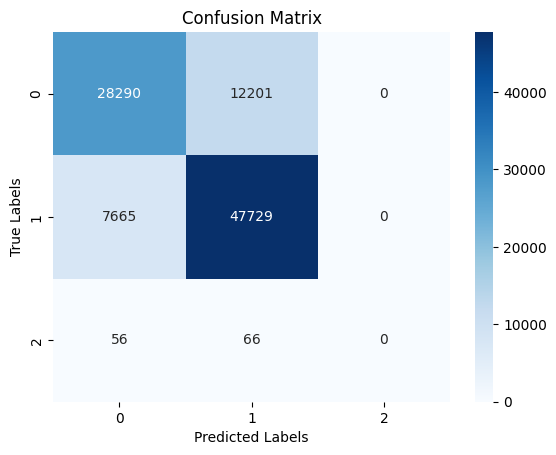

Classification Report:

              precision    recall  f1-score   support

           0     0.7856    0.6987    0.7396     40491
           1     0.7955    0.8616    0.8273     55394
           2     0.0000    0.0000    0.0000       122

    accuracy                         0.7918     96007
   macro avg     0.5270    0.5201    0.5223     96007
weighted avg     0.7903    0.7918    0.7892     96007

Training model: GraphSAGE
Epoch 00000 | Loss 1.3113 | Train Acc 0.0087
Epoch 00010 | Loss 0.5623 | Train Acc 0.8225
Epoch 00020 | Loss 0.3472 | Train Acc 0.8623
Epoch 00030 | Loss 0.3112 | Train Acc 0.8767
Epoch 00040 | Loss 0.2816 | Train Acc 0.8926
Logits test shape:  torch.Size([96007, 3])


/home/valentina/Desktop/GIT/TrabajoTesis/env310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/env310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/env310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

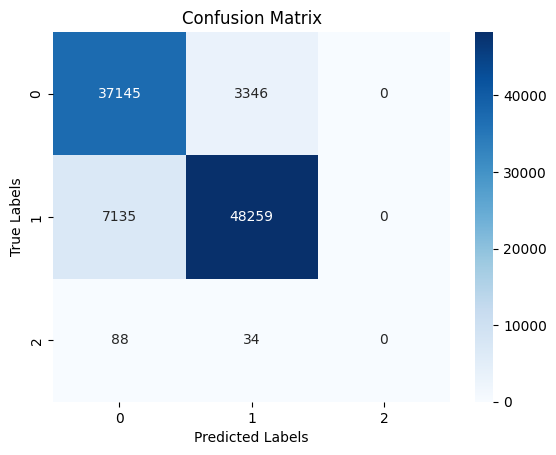

Classification Report:

              precision    recall  f1-score   support

           0     0.8372    0.9174    0.8755     40491
           1     0.9345    0.8712    0.9018     55394
           2     0.0000    0.0000    0.0000       122

    accuracy                         0.8896     96007
   macro avg     0.5906    0.5962    0.5924     96007
weighted avg     0.8923    0.8896    0.8895     96007

Training model: GAT
Epoch 00000 | Loss 1.0669 | Train Acc 0.4245
Epoch 00010 | Loss 0.6567 | Train Acc 0.5758
Epoch 00020 | Loss 0.5063 | Train Acc 0.7769
Epoch 00030 | Loss 0.4324 | Train Acc 0.8138
Epoch 00040 | Loss 0.3865 | Train Acc 0.8369
Logits test shape:  torch.Size([96007, 3])


/home/valentina/Desktop/GIT/TrabajoTesis/env310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/env310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/env310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

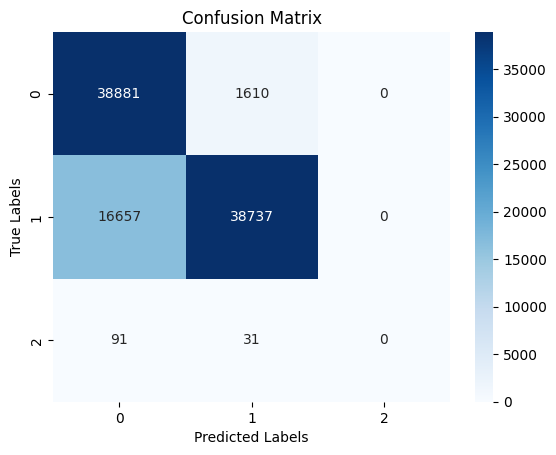

Classification Report:

              precision    recall  f1-score   support

           0     0.6989    0.9602    0.8090     40491
           1     0.9594    0.6993    0.8089     55394
           2     0.0000    0.0000    0.0000       122

    accuracy                         0.8085     96007
   macro avg     0.5528    0.5532    0.5393     96007
weighted avg     0.8483    0.8085    0.8079     96007



In [48]:
decorer = 'DotProduct'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 32 
out_feats = 16
out_feats_mlp = 3
labels_train = gnn.train_g.edata["Relationship"].to(torch.int64)

for model_name in models:
    print("Training model: {}".format(model_name))
    
    model = models[model_name](
    in_feats=in_feats,
    hidden_feats=hidden_feats,
    out_feats=out_feats,
    out_feats_mlp=out_feats_mlp,)

    optimizer = torch.optim.Adam(itertools.chain(model.parameters()), lr=0.01)

    # ----------- training -------------------------------- #
    
    
    loss_values = []
    acc_train = []
    train_error = []
    model_complexity = []

    for e in range(50):

        # forward
        model.train()
        h = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])
        logits = model.decodeMLP(gnn.train_g, h)
        scores = logits.argmax(1)

        # Calcular la pérdida en el conjunto de entrenamiento
        train_loss = F.cross_entropy(logits, labels_train)
        train_error.append(train_loss.item())
            
        # Guardar la complejidad del modelo (en este caso, usamos el número de épocas)
        model_complexity.append(e + 1)
        
        # Almacenar el valor de pérdida
        loss_values.append(train_loss.item())
        
        # Calcular la precisión en el conjunto de entrenamiento
        train_acc = (scores == labels_train).float().mean().item()

        # backward
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print("Epoch {:05d} | Loss {:.4f} | Train Acc {:.4f}".format(e, train_loss.item(), train_acc))

        
    # ----------- 5. check results ------------------------ #


    with torch.no_grad():
        h = model.encode(gnn.test_pos_g, gnn.test_pos_g.ndata["feat"])
        logits_test = model.decodeMLP(gnn.test_pos_g, h)
        print("Logits test shape: ", logits_test.shape)
        predicted_scores_test = logits_test.argmax(1)
        true_values_test = gnn.test_pos_g.edata["Relationship"].to(torch.int64)
        
        conf_matrix = confusion_matrix(true_values_test, predicted_scores_test)
        report = classification_report(true_values_test, predicted_scores_test, digits=4)

        # Graficar la matriz de confusión
        plt.figure()
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

        print("Classification Report:\n")
        print(report)  
    


    
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")


     
    
